In [1]:
import datetime
import time
import numpy as np
import pandas as pd
from packaging import version
from collections import Counter
import re

from math import sqrt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.preprocessing.text import Tokenizer
import string
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from keras import backend as K
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Input, Dense, Embedding, GlobalMaxPool1D
from tensorflow.keras.layers import Conv1D, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, SimpleRNN, TextVectorization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

tf.keras.utils.set_random_seed(7)
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)
pd.set_option('max_colwidth', 600)

In [2]:

!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 636 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [3]:
!pip install -q -U keras-tuner
import keras_tuner as kt
from keras_tuner import Objective, HyperParameters

     |████████████████████████████████| 135 kB 31.1 MB/s 
     |████████████████████████████████| 1.6 MB 45.1 MB/s 


In [4]:
import yfinance as yf

In [5]:
!pip install talib-binary
import talib as ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.4 MB 30.4 MB/s 


In [6]:
#getting initial stock data
stock="VZ"
obj = yf.Ticker(stock)
stock_data=obj.history(interval="1d", start="2012-10-01", end="2022-09-30")

In [7]:
#data shape
stock_data.shape

(2516, 7)

In [8]:
stock_data.shape

(2516, 7)

In [9]:
stock_data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2012-10-01 00:00:00-04:00,28.653600,30.618670,28.502925,28.760330,28873700,0.000,0
2012-10-02 00:00:00-04:00,28.860766,28.923547,28.641029,28.791706,10326800,0.000,0
2012-10-03 00:00:00-04:00,28.867043,29.130727,28.766592,29.055387,11907200,0.000,0
2012-10-04 00:00:00-04:00,29.137010,29.683211,29.137010,29.670654,16112600,0.000,0
2012-10-05 00:00:00-04:00,29.788069,30.035615,29.718248,29.864237,16909200,0.515,0


In [10]:
#removing dividends and stocks splits
data=stock_data.iloc[:, :5]

In [11]:
#data.to_csv("aapl_prices_vol.csv")

Text(0.5, 0, '')

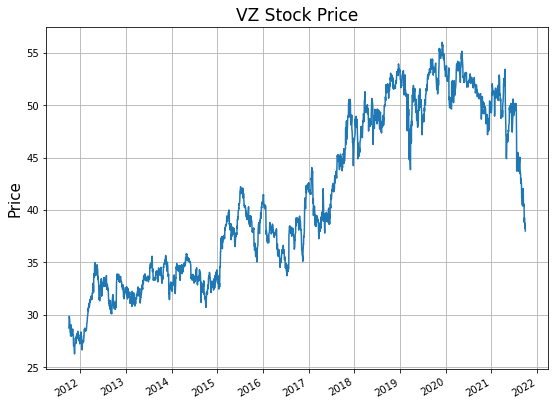

In [12]:
#plot of stock price over the 10-year period
data["Close"].plot(figsize=(9,7))
plt.grid(True)
plt.title("{} Stock Price".format(stock), size =17)
plt.ylabel("Price", size=15)
plt.xlabel("")

In [13]:
#adding technical indicators
seq_len=21
data["MA_20"]= ta.SMA(data["Close"], timeperiod=20)
data["MA_50"]= ta.SMA(data["Close"], timeperiod=50)
data["EXP_MA_20"]= ta.EMA(data["Close"], timeperiod=20)
data["EXP_MA_50"]= ta.EMA(data["Close"], timeperiod=50)
data["RSI"] =ta.RSI(data["Close"],timeperiod=seq_len)
data["MACD"],data["MACD_sign"], data["MACD_hist"]  =ta.MACD( data["Close"].values )
data["BB_upper"], data["BB_middle"], data["BB_lower"] = ta.BBANDS(data["Close"], timeperiod=seq_len, nbdevup=2, nbdevdn=2, matype=0)
data["PPO"]= ta.PPO(data["Close"])
data["MOM"]=ta.MOM(data["Close"], timeperiod=seq_len)
data["Rate_Of_Change"]=ta.ROCP(data["Close"], timeperiod=1)

In [14]:
#data.to_csv("aapl_prices_vol_tech.csv")

In [15]:
#technical variables have up to 50 days as n/a due to how they are constructed (example 50-day moving avarage)
data.head()

,Open,High,Low,Close,Volume,MA_20,MA_50,EXP_MA_20,EXP_MA_50,RSI,MACD,MACD_sign,MACD_hist,BB_upper,BB_middle,BB_lower,PPO,MOM,Rate_Of_Change
Date,,,,,,,,,,,,,,,,,,,
2012-10-01 00:00:00-04:00,28.653600,30.618670,28.502925,28.760330,28873700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-10-02 00:00:00-04:00,28.860766,28.923547,28.641029,28.791706,10326800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001091
2012-10-03 00:00:00-04:00,28.867043,29.130727,28.766592,29.055387,11907200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.009158
2012-10-04 00:00:00-04:00,29.137010,29.683211,29.137010,29.670654,16112600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.021176
2012-10-05 00:00:00-04:00,29.788069,30.035615,29.718248,29.864237,16909200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.006524


In [16]:
#removing the n/a's from technical variable creation
data=data.iloc[49:,:]

In [17]:
data.head()

,Open,High,Low,Close,Volume,MA_20,MA_50,EXP_MA_20,EXP_MA_50,RSI,MACD,MACD_sign,MACD_hist,BB_upper,BB_middle,BB_lower,PPO,MOM,Rate_Of_Change
Date,,,,,,,,,,,,,,,,,,,
2012-12-12 00:00:00-05:00,28.302809,28.524965,28.194903,28.429756,10741000,27.606185,28.067975,27.885448,28.067975,54.720359,0.090271,-0.041451,0.131722,28.735886,27.577395,26.418904,1.573130,1.415459,0.007876
2012-12-13 00:00:00-05:00,28.461488,28.461488,28.137775,28.258373,8303600,27.678544,28.057936,27.920965,28.075442,52.872785,0.105424,-0.012076,0.117500,28.800408,27.637241,26.474075,1.849144,1.256767,-0.006028
2012-12-14 00:00:00-05:00,28.194907,28.455150,28.048918,28.061613,10604700,27.758204,28.043334,27.934360,28.074900,50.804940,0.100399,0.010419,0.089980,28.811730,27.696786,26.581841,1.881873,1.250431,-0.006963
2012-12-17 00:00:00-05:00,28.086995,28.118731,27.839449,28.004478,12605300,27.844527,28.022316,27.941038,28.072138,50.206260,0.090760,0.026487,0.064273,28.745805,27.769931,26.794058,1.766865,1.536055,-0.002036
2012-12-18 00:00:00-05:00,28.004482,28.029872,27.572862,27.845798,24653200,27.878168,27.985819,27.931968,28.063262,48.538300,0.069515,0.035093,0.034422,28.556740,27.844588,27.132436,1.608391,1.567793,-0.005666


In [18]:
#checking that there are no NAs.
print(data.isna().sum())

Open              0
High              0
Low               0
Close             0
Volume            0
MA_20             0
MA_50             0
EXP_MA_20         0
EXP_MA_50         0
RSI               0
MACD              0
MACD_sign         0
MACD_hist         0
BB_upper          0
BB_middle         0
BB_lower          0
PPO               0
MOM               0
Rate_Of_Change    0
dtype: int64


In [19]:
#creating X features  in the shape of [observations by time steps by features], which is neccessary for LSTMs. The y labels are in vector shape. 
X_samples=[]
y_samples=[]
num_features=data.shape[1]
num_rows=len(data)
#time steps are approximetly a month
seq_len=21

for i in range(seq_len, num_rows):
  x_step=data[i-seq_len: i]
  y_step=data["Close"][i]
  X_samples.append(x_step)
  y_samples.append(y_step)

X_data=np.array(X_samples)
X_data=X_data.reshape(X_data.shape[0], X_data.shape[1], num_features)
print(X_data.shape)

y_data=np.array(y_samples)
y_data=y_data.reshape(y_data.shape[0],1)

#checking shape
print(y_data.shape)

(2446, 21, 19)
(2446, 1)


In [20]:
#X_data[-1]

In [21]:
#data.tail()

In [22]:
#creating train and validation sets for hyperparameter tuning. (X_test is created for completeness
# but will not be utilized in the hyperparameter tunning stage. Instead a final test set will be created below for use in the final model
#after hyperparameter tunning is complete)  

# Choosing the number of validation set observations
valsplit=500
testsplit=250
# Splitting the data into train and validation sets
X_train=X_data[:-valsplit]
X_val=X_data[-valsplit:-testsplit]
X_test=X_data[-testsplit:]
y_train=y_data[:-valsplit]
y_val=y_data[-valsplit:-testsplit]
y_test=y_data[-testsplit:]

In [23]:
# Printing the shape of training and validation
print('\n#### Training Data shape ####')
print(X_train.shape)
print(y_train.shape)
print('\n#### Validation Data shape ####')
print(X_val.shape)
print(y_val.shape)
print('\n#### Testing Data shape ####')
print(X_test.shape)
print(y_test.shape)


#### Training Data shape ####
(1946, 21, 19)
(1946, 1)

#### Validation Data shape ####
(250, 21, 19)
(250, 1)

#### Testing Data shape ####
(250, 21, 19)
(250, 1)


In [24]:
#using MinMaxScaler to fit_transform on the train set and then just transform on the validation set so as to avoid data leakage 
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

scaler_y=MinMaxScaler()
y_train=scaler_y.fit_transform(y_train)
y_val=scaler_y.transform(y_val)
y_test=scaler_y.transform(y_test)

In [25]:
#Creating final train and test sets. This data is for the final model after the best model using hyperparameter tuning has been identified. 
#the train set now consists of the train and validation set observations. The test set data has not been observed by any model.
# Choosing the number of testing data records
testingsplit=250
 

X_final_train=X_data[:-testingsplit]
X_final_test=X_data[-testingsplit:]
y_final_train=y_data[:-testingsplit]
y_final_test=y_data[-testingsplit:]

In [26]:
print('\n#### Training Data shape ####')
print(X_final_train.shape)
print(y_final_train.shape)

print('\n#### Testing Data shape ####')
print(X_final_test.shape)
print(y_final_test.shape)


#### Training Data shape ####
(2196, 21, 19)
(2196, 1)

#### Testing Data shape ####
(250, 21, 19)
(250, 1)


In [27]:
#scalling the data for the final analysis after the train-validation stage. The scaler is different from before as it scales the train data set that is now composed of 
#the train and validation sets.
scaler_final_X=MinMaxScaler()
X_final_train = scaler_final_X.fit_transform(X_final_train.reshape(-1, X_final_train.shape[-1])).reshape(X_final_train.shape)
X_final_test = scaler_final_X.transform(X_final_test.reshape(-1, X_final_test.shape[-1])).reshape(X_final_test.shape)

scaler_final_y=MinMaxScaler()
y_final_train=scaler_final_y.fit_transform(y_final_train)
y_final_test=scaler_final_y.transform(y_final_test)

##Helpful Model Fitting and Results Functions

In [28]:
#function for compiling and training the model. 
def compile_train_model(model, x_train, y_train,  epochs=100, x_valid=None, y_valid=None, patience=3, optimizer='adam', final_model=False):
    
  
    # Compile
    model.compile(optimizer=optimizer,
                loss = 'mse',
                metrics=['mse'])
    

  # Train if final model there is no validation set.
    if final_model:
     
      history = model.fit(
        x_train,
        y_train,
        epochs=epochs,
        batch_size=32,
        verbose=1,
        callbacks=[    
          EarlyStopping(monitor='mse', patience=patience, restore_best_weights=True, verbose=0)]
            )
      
    else:
     
      history = model.fit(
        x_train,
        y_train,
        epochs=epochs,
        batch_size=32,
        validation_data=(x_valid, y_valid),
        verbose=1,
        callbacks=[    
          EarlyStopping(monitor='val_mse', patience=patience, restore_best_weights=True, verbose=0)]
            )
    return history, model   
    

In [29]:
#creating function for charts of train vs validation loss functions
def train_val_loss_charts(model_history, model_num):
    model_df=pd.DataFrame(model_history.history)

    model_df[["loss","val_loss"]].plot(figsize=(9,7))
    plt.grid(True)
    plt.title("Transformer - Train vs. Validation - Loss for {}".format(model_num), size =17)
    plt.xlabel("Epochs", size=15)

    plt.show()    

In [30]:
#from https://www.statology.org/matplotlib-abline/
def abline(slope, intercept):
     axes = plt.gca()
     x_vals = np.array(axes.get_xlim())
     y_vals = intercept + slope * x_vals
     plt.plot(x_vals, y_vals, '--', color="red")


In [31]:
#creating rmse, MAPE, MAE and R calculation for price levels using inverese_transform on the y_scaller

def price_level_evaluation_stats(model, X_train, y_train, X_test, y_test, stock, final_model=False):
    
    if final_model:

      #getting final model predictions for train and test
      train_predict=model.predict(X_train,verbose=0)
      test_predict=model.predict(X_test,verbose=0)

      #unscaling to get price level predictions
      train_predict_level=scaler_final_y.inverse_transform(train_predict)
      test_predict_level=scaler_final_y.inverse_transform(test_predict)

      #unscaling actual values
      train_actual_level=scaler_final_y.inverse_transform(y_train)
      test_actual_level=scaler_final_y.inverse_transform(y_test)

      #calculating MSE
      train_RMSE=sqrt(MSE(train_actual_level,train_predict_level ))
      test_RMSE=sqrt(MSE(test_actual_level,test_predict_level ))

      print("Final Model - Train Set RMSE: {}".format(train_RMSE))
      print("Final Model - Test Set RMSE: {}".format(test_RMSE))
      print("\n")
      #calculating MAPE
      train_MAPE=MAPE(train_actual_level,train_predict_level )
      test_MAPE=MAPE(test_actual_level,test_predict_level )

      print("Final Model - Train Set MAPE: {}".format(train_MAPE))
      print("Final Model - Test Set MAPE: {}".format(test_MAPE))
      print("\n")

      #calculating MAE
      train_MAE=MAE(train_actual_level,train_predict_level )
      test_MAE=MAE(test_actual_level,test_predict_level )

      print("Final Model - Train Set MAE: {}".format(train_MAE))
      print("Final Model - Test Set MAE: {}".format(test_MAE))
      print("\n")

      #calculating correl_coefficent between actual and predicted
      train_R=np.corrcoef(train_actual_level.reshape(-1),train_predict_level.reshape(-1) )
      test_R=np.corrcoef(test_actual_level.reshape(-1),test_predict_level.reshape(-1) )

      print("Final Model - Train Set R: {}".format(np.round(train_R[0,1],4)))
      print("Final Model - Test Set R: {}".format(np.round(test_R[0,1],4)))
      print("\n")

      #model_df=pd.DataFrame(model_history.history)

      #model_df[["loss","val_loss"]].plot(figsize=(9,7))
      plt.figure(figsize=(9, 7))
      plt.scatter(test_actual_level.reshape(-1),test_predict_level.reshape(-1))
      plt.grid(True)
      plt.title("Transformer - Actual vs. Predicted {} Prices Scatterplot".format(stock), size =17)
      plt.xlabel("Actual", size=15)
      plt.ylabel("Predictions", size=15)
      abline(1,0)
      plt.show() 
    
    else:

      #getting model predictions for train and val 
      train_predict=model.predict(X_train,verbose=0)
      val_predict=model.predict(X_test,verbose=0)
     

      #unscaling to get price level predictions
      train_predict_level=scaler_y.inverse_transform(train_predict)
      val_predict_level=scaler_y.inverse_transform(val_predict)
      

      #unscaling actual values
      train_actual_level=scaler_y.inverse_transform(y_train)
      val_actual_level=scaler_y.inverse_transform(y_test)
      

      #calculating RMSE
      train_RMSE=sqrt(MSE(train_actual_level,train_predict_level ))
      val_RMSE=sqrt(MSE(val_actual_level,val_predict_level ))
      
      print("Train Set RMSE: {}".format(train_RMSE))
      print("Val Set RMSE: {}".format(val_RMSE))
      print("\n")

      #calculating MAPE
      train_MAPE=MAPE(train_actual_level,train_predict_level )
      val_MAPE=MAPE(val_actual_level,val_predict_level )
      
      print("Train Set MAPE: {}".format(train_MAPE))
      print("Val Set MAPE: {}".format(val_MAPE))
      print("\n")

      #calculating MAPE
      train_MAE=MAE(train_actual_level,train_predict_level )
      val_MAE=MAE(val_actual_level,val_predict_level )
      

      print("Train Set MAE: {}".format(train_MAE))
      print("Val Set MAE: {}".format(val_MAE))
      print("\n")

      #calculating correl_coefficent between actual and predicted
      train_R=np.corrcoef(train_actual_level.reshape(-1),train_predict_level.reshape(-1) )
      val_R=np.corrcoef(val_actual_level.reshape(-1),val_predict_level.reshape(-1) )
      

      print("Train Set R: {}".format(np.round(train_R[0,1],4)))
      print("Val Set R: {}".format(np.round(val_R[0,1],4)))
      print("\n")

      plt.figure(figsize=(9, 7))
      plt.scatter(val_actual_level.reshape(-1),val_predict_level.reshape(-1))
      plt.grid(True)
      plt.title("Transformer - Actual vs. Predicted {} Prices Scatterplot".format(stock), size =17)
      plt.xlabel("Actual", size=15)
      plt.ylabel("Predictions", size=15)
      abline(1,0)
      plt.show()


In [32]:
def actual_predicted_test_set_chart(model, X_final_test,y_final_test, model_number):
      #getting final model predictions for test set
      test_predict=model.predict(X_final_test,verbose=0)

      #unscaling to get price level predictions
      test_predict_level=scaler_final_y.inverse_transform(test_predict)

      #unscaling actual values
      test_actual_level=scaler_final_y.inverse_transform(y_final_test)

      #creating dataframe and setting dates as the index
      df_actual_predicted=pd.DataFrame([test_predict_level.reshape(-1), test_actual_level.reshape(-1)]).T
      df_actual_predicted.rename(columns={0: "Predicted", 1: "Actual"}, inplace=True)
      df_actual_predicted["dates"]=data.index[-250:]
      df_actual_predicted.set_index("dates", inplace=True)

      #creating chart of Predicted vs. Actual
      df_actual_predicted[["Predicted", "Actual"]].plot(figsize=(9,7))
      plt.grid(True)
      plt.title("Transformer - Actual vs. Predicted Prices: {}".format(model_number), size =17)
      plt.ylabel("Price", size=15)
      plt.xlabel("")
     
      


In [33]:
def actual_predicted_train_test_set_chart(model, X_train, y_train, X_test, y_test, stock):
      #getting final model predictions for train and test
      train_predict=model.predict(X_train,verbose=0)
      test_predict=model.predict(X_test,verbose=0)

      #unscaling to get price level predictions
      train_predict_level=scaler_final_y.inverse_transform(train_predict)
      test_predict_level=scaler_final_y.inverse_transform(test_predict)

      #unscaling actual values
      train_actual_level=scaler_final_y.inverse_transform(y_train)
      test_actual_level=scaler_final_y.inverse_transform(y_test)

      #combine time series
      total_actual_level=np.concatenate((train_actual_level,test_actual_level))
      total_predict_level=np.concatenate((train_predict_level, test_predict_level))

      #creating dataframe and setting dates as the index
      df_actual_predicted=pd.DataFrame([total_predict_level.reshape(-1), total_actual_level.reshape(-1)]).T
      df_actual_predicted.rename(columns={0: "Predicted", 1: "Actual Prices"}, inplace=True)
      df_actual_predicted["dates"]=data.index[-2446:]
      df_actual_predicted.set_index("dates", inplace=True)
      #separating the train and test set into separate series so as to use different colors
      df_actual_predicted['Predicted Prices Train Set'] = np.where(df_actual_predicted.index<="2021-10-04", df_actual_predicted["Predicted"], np.NaN)
      df_actual_predicted['Predicted Prices Test Set'] = np.where(df_actual_predicted.index>="2021-10-04", df_actual_predicted["Predicted"], np.NaN)
      
      #creating chart of Predicted vs. Actual 

      #cycler to assign different colors, linestyles and linewidths to the three series
      cycler = plt.cycler(color= ['k','g','b'],
                          linestyle=['-', '-', '-'],
                          linewidth=[1,1.5,1.5])
                   
      fig, ax = plt.subplots()
      ax.set_prop_cycle(cycler)
      df_actual_predicted[["Actual Prices",'Predicted Prices Train Set', 'Predicted Prices Test Set']].plot(figsize=(9,7), ax=ax)
      plt.grid(True)
      
      plt.title("Transformer - Actual vs. Predicted Prices: {}".format(model_number), size =17)
      plt.ylabel("Price", size=15)
      plt.xlabel("")
      
     

In [34]:
# Function for creating confusion matrix

#class names for confusion matrix
class_names = ["Price Down Next Day", "Price Up Next Day"]


def confusion_matrix_stocks(model_for_matrix, predicted_values, actual_test_labels, model_num):
    



    #creating confusion matrix - using test set labels as they were already sparse before one-hot encoding
    confusion_matrix_for_model = confusion_matrix(actual_test_labels ,  predicted_values)


    confusion_matrix_df = pd.DataFrame(confusion_matrix_for_model,
                    
                     index=class_names,
                     columns=class_names)

    #Plotting the confusion matrix
    plt.figure(figsize=(10,8))
    ax=sns.heatmap(confusion_matrix_df,annot=True, fmt="d", cmap="rocket_r", annot_kws={"size":25})
    cax = ax.figure.axes[-1]
    cax.tick_params(labelsize=22)
    plt.title('Transformer - Confusion Matrix - {}'.format(model_num), size=25)
    plt.ylabel('Actual Labels', size=22)
    plt.xlabel('Predicted Labels',size=22)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.show() 

In [35]:
def test_set_classification_report(model, X_final_test,y_final_test, model_number):
      #getting final model predictions for train and test
      test_predict=model.predict(X_test,verbose=0)

      #unscaling to get price level predictions
      test_predict_level=scaler_final_y.inverse_transform(test_predict)

      #unscaling actual values
      test_actual_level=scaler_final_y.inverse_transform(y_test)
      
      #creating dataframe 
      df_actual_predicted=pd.DataFrame([test_predict_level.reshape(-1), test_actual_level.reshape(-1)]).T
      df_actual_predicted.rename(columns={0: "Predicted", 1: "Actual"}, inplace=True)
      
      #creating forecasted signal for next day from past day actual price. 0 if level price forecast is less than or equal to yesterday's actual price, and
      #1 for above. 
      predicted_signal=[0]
      for i in range(1,250):
        if df_actual_predicted.iloc[i, 0]>df_actual_predicted.iloc[i-1,1]:
          predicted_signal.append(1)
        else:
          predicted_signal.append(0)
      #creating  signal for next day from past day actual price. 0 if level of actual next day price is less than or equal to yesterday's actual price, and
      #1 for above.
      actual_signal=[0]
      for i in range(1,250):
        if df_actual_predicted.iloc[i, 1]>df_actual_predicted.iloc[i-1,1]:
          actual_signal.append(1)
        else:
          actual_signal.append(0)
      print(classification_report(actual_signal[1:], predicted_signal[1:]))
      accuracy=accuracy_score(actual_signal[1:], predicted_signal[1:])

      print("Test Set Accuracy for {} is {}".format(model_number, accuracy))

      print("\n")
      print("\n")
      
      confusion_matrix_stocks(model,predicted_signal[1:], actual_signal[1:], model_number)

##Model Hyper-parameter Tuning using Train and Validation Sets 

In [36]:
#Time2Vec class implementation. Code adjusted from https://medium.com/@dave.cote.msc/hands-on-advanced-deep-learning-time-series-forecasting-with-tensors-7facae522f18

class Time2Vec(layers.Layer):
  def __init__(self, seq_len, **kwargs):
    super(Time2Vec, self).__init__()
    self.seq_len=seq_len

  def build(self, input_shape):

    self.weights_linear=self.add_weight(name="beta_linear", 
                                       shape=(int(self.seq_len),),
                                       initializer="uniform",
                                       trainable=True)
    self.bias_linear=self.add_weight(name="bias_linear", 
                                       shape=(int(self.seq_len),),
                                       initializer="uniform",
                                       trainable=True)
    self.weights_periodic=self.add_weight(name="beta_periodic", 
                                       shape=(int(self.seq_len),),
                                       initializer="uniform",
                                       trainable=True)
    self.bias_periodic=self.add_weight(name="bias_periodic", 
                                       shape=(int(self.seq_len),),
                                       initializer="uniform",
                                       trainable=True)


  def call(self, x):

    x=tf.math.reduce_mean(x[:,:,:], axis=-1)
    time_linear=self.weights_linear*x + self.bias_linear
    time_linear=tf.expand_dims(time_linear, axis=-1)

    time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) +self.bias_periodic)
    time_periodic=tf.expand_dims(time_periodic, axis=-1)

    return tf.concat([time_linear, time_periodic], axis=-1)

  def get_config(self):                                 
    config = super(Time2Vec, self).get_config()
    config.update({
            "seq_len": self.seq_len
            

        })
    return config



In [ ]:
#code from 
def transformer_encoder(inputs, head_dim, num_heads, con1D_dim, dropout=0):
    # Normalization and Attention
    #x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.BatchNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_dim, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    #x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.BatchNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=con1D_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [ ]:
input_shape = X_data.shape[1:]
#def transformer_model(hp, head_dim, num_heads, con1D_dim, num_transformer_blocks, mlp_dim, dropout=0, mlp_dropout=0):
def transformer_model(hp):

    time_embedding = Time2Vec(seq_len)
    #in_seq=Input(shape=(seq_len, 5))
    inputs=keras.Input(shape=input_shape)
    x=time_embedding(inputs)
    x=layers.Concatenate(axis=-1)([inputs, x])


    for i in range(hp.Int("number_transformer_blocks", 2,8, step=2)):
      x=transformer_encoder(x, 
                            head_dim =hp.Int('Head_dim_{}_units'.format(i),min_value=128,max_value=256,step=32), 
                            num_heads =hp.Int('Num_heads_{}'.format(i),min_value=2,max_value=8,step=2), 
                            con1D_dim=hp.Int('conv1D_dim_{}'.format(i),min_value=4,max_value=16,step=4), 
                            dropout=hp.Float("t_block_dropout_{}".format(i), min_value=0.10, max_value=0.40, step=0.10))
    
    x=GlobalAveragePooling1D(data_format="channels_first")(x)  
    
    x=Dense(units=hp.Int('mlp_dim_units',min_value=128,max_value=256,step=32), activation="relu")(x)
    x=Dropout(hp.Float("mlp_dropout", min_value=0.10, max_value=0.40, step=0.10))(x)

    outputs=Dense(1, activation="linear")(x)
    model=Model(inputs, outputs) 
    model.compile(loss="mse", optimizer="adam", metrics=["mse"])
    return model 



In [ ]:
#creating Bayesian Optimization for KerasTuner
model_tuner = kt.BayesianOptimization(
    hypermodel=transformer_model,
    objective="val_mse",
    max_trials=20,
    overwrite=True,
    directory='/content/gdrive/My Drive/Colab Notebooks/MSDS_498/keras_tuner_out',
    project_name=stock)

In [ ]:
epochs=40
patience=5

early_stopping= EarlyStopping(monitor='val_mse',patience=patience, restore_best_weights=True )

#tunning the model
model_tuner.search(X_train, y_train, epochs=epochs, batch_size=32, validation_data=(X_val, y_val), callbacks= [early_stopping])

Trial 20 Complete [00h 00m 15s]
val_mse: 0.0012099849991500378

Best val_mse So Far: 0.0003495581040624529
Total elapsed time: 00h 10m 26s


In [ ]:
#getting best hyperparameters
model_best_hyper_parameters=model_tuner.get_best_hyperparameters(num_trials=1)[0]

#function to print out best parameters depending on how many LSTM layers there are
def best_model_hyperparameters(bhp):
    
    num_blocks=bhp.get('number_transformer_blocks')
    print("Number of Transformer Blocks: {}".format(num_blocks))
    print("\n")
    for i in range(0,num_blocks):
        print("Block {} numer of heads: ".format(i), bhp.get("Num_heads_{}".format(i)))
        print("Block {} head dimension units: ".format(i), bhp.get("Head_dim_{}_units".format(i)))
        print("Block {} Conv1D dimension units: ".format(i), bhp.get("conv1D_dim_{}".format(i)))
        print("Block {} Dropout: ".format(i),np.round( bhp.get("t_block_dropout_{}".format(i)),3 )  )
        print("\n")
    
    print("mlp dimension units: ", bhp.get("mlp_dim_units"))
    
    print("mlp Dropout: ",np.round( bhp.get("mlp_dropout"),3 )  )
    print("\n")
    #print("Optimizer Used: {}".format(bhp.get('optimizer')))                                                           

#printing out best model hyperparameters
best_model_hyperparameters(model_best_hyper_parameters)  

Number of Transformer Blocks: 2


Block 0 numer of heads:  8
Block 0 head dimension units:  256
Block 0 Conv1D dimension units:  4
Block 0 Dropout:  0.4


Block 1 numer of heads:  4
Block 1 head dimension units:  224
Block 1 Conv1D dimension units:  4
Block 1 Dropout:  0.4


mlp dimension units:  256
mlp Dropout:  0.1




In [ ]:
#getting paremeters of best model
tf.keras.utils.set_random_seed(10)
model_best_params = model_tuner.get_best_hyperparameters(2)

# Building model with best hyper parameters
model_best = transformer_model(model_best_params[0])

# Running best model. 
epochs=40
patience=5
model_number=stock

#best_model_optimizer=model_best_hyper_parameters.get('optimizer')
history_best_model, best_model = compile_train_model(model_best,
                                    X_train,y_train, epochs=epochs,
                                     x_valid=X_val,y_valid=y_val,patience=patience,
                                    optimizer="adam")

Epoch 1/40
61/61 [==============================] - 5s 19ms/step - loss: 0.0403 - mse: 0.0403 - val_loss: 0.0653 - val_mse: 0.0653
Epoch 2/40
61/61 [==============================] - 1s 13ms/step - loss: 0.0058 - mse: 0.0058 - val_loss: 0.0097 - val_mse: 0.0097
Epoch 3/40
61/61 [==============================] - 1s 14ms/step - loss: 0.0045 - mse: 0.0045 - val_loss: 0.0051 - val_mse: 0.0051
Epoch 4/40
61/61 [==============================] - 1s 12ms/step - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0126 - val_mse: 0.0126
Epoch 5/40
61/61 [==============================] - 1s 13ms/step - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 6/40
61/61 [==============================] - 1s 12ms/step - loss: 0.0030 - mse: 0.0030 - val_loss: 0.0029 - val_mse: 0.0029
Epoch 7/40
61/61 [==============================] - 1s 12ms/step - loss: 0.0031 - mse: 0.0031 - val_loss: 8.0644e-04 - val_mse: 8.0644e-04
Epoch 8/40
61/61 [==============================] - 1s 12ms/step - loss: 0.

In [ ]:
best_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 21, 19)]     0           []                               
                                                                                                  
 time2_vec_3 (Time2Vec)         (None, 21, 2)        84          ['input_4[0][0]']                
                                                                                                  
 concatenate_3 (Concatenate)    (None, 21, 21)       0           ['input_4[0][0]',                
                                                                  'time2_vec_3[0][0]']            
                                                                                                  
 batch_normalization_12 (BatchN  (None, 21, 21)      84          ['concatenate_3[0][0]']    

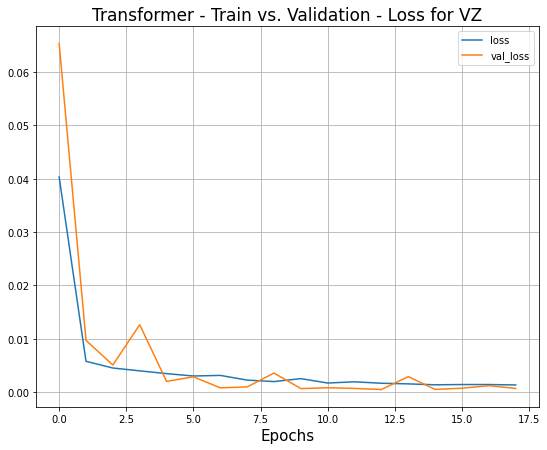

In [ ]:

train_val_loss_charts(history_best_model, model_number)

Train Set RMSE: 0.7026360989265077
Val Set RMSE: 0.6183987455270306


Train Set MAPE: 0.014120017315520535
Val Set MAPE: 0.008621793398834388


Train Set MAE: 0.5375744583427845
Val Set MAE: 0.4552600860595703


Train Set R: 0.9957
Val Set R: 0.9016




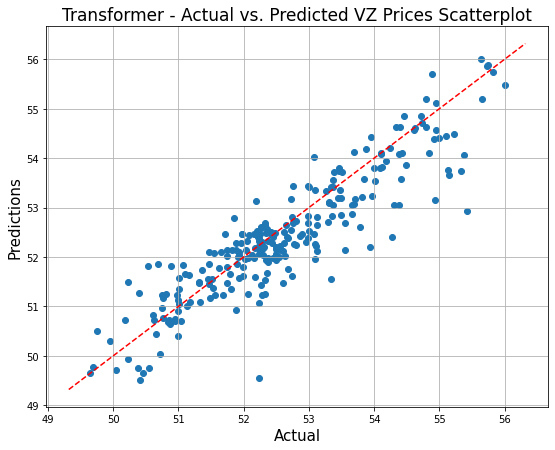

In [ ]:
price_level_evaluation_stats(best_model, X_train, y_train, X_val, y_val,stock)


In [ ]:
best_model.save( '/content/gdrive/My Drive/Colab Notebooks/MSDS_498/saved_models/transformer_model_val_VZ.h5')

In [ ]:
#model = tf.keras.models.load_model('/content/gdrive/My Drive/Colab Notebooks/MSDS_498/saved_models/transformer_model_val_PFE.h5',custom_objects={"Time2Vec": Time2Vec })

#Final Best Model Estimation

In [ ]:
tf.keras.utils.set_random_seed(100)
#getting paremeters of best model
model_best_params = model_tuner.get_best_hyperparameters(2)
   
# Building model with best hyper parameters 
model_best = transformer_model(model_best_params[0])

# Running best model using final train and test sets. Test set metrics will be 
#based of this model run.
epochs=40
patience=5
 
#best_model_optimizer=model_best_hyper_parameters.get('optimizer')
history_best_model_test, best_model_test = compile_train_model(model_best, X_final_train,y_final_train,
                                    epochs=epochs,patience=patience,
                                    optimizer="adam", final_model=True)

Epoch 1/40
69/69 [==============================] - 3s 12ms/step - loss: 0.0631 - mse: 0.0631
Epoch 2/40
69/69 [==============================] - 1s 12ms/step - loss: 0.0064 - mse: 0.0064
Epoch 3/40
69/69 [==============================] - 1s 12ms/step - loss: 0.0043 - mse: 0.0043
Epoch 4/40
69/69 [==============================] - 1s 11ms/step - loss: 0.0034 - mse: 0.0034
Epoch 5/40
69/69 [==============================] - 1s 11ms/step - loss: 0.0034 - mse: 0.0034
Epoch 6/40
69/69 [==============================] - 1s 12ms/step - loss: 0.0031 - mse: 0.0031
Epoch 7/40
69/69 [==============================] - 1s 12ms/step - loss: 0.0023 - mse: 0.0023
Epoch 8/40
69/69 [==============================] - 1s 12ms/step - loss: 0.0020 - mse: 0.0020
Epoch 9/40
69/69 [==============================] - 1s 12ms/step - loss: 0.0021 - mse: 0.0021
Epoch 10/40
69/69 [==============================] - 1s 11ms/step - loss: 0.0019 - mse: 0.0019
Epoch 11/40
69/69 [==============================] - 1s 12m

Final Model - Train Set RMSE: 0.7813139813729261
Final Model - Test Set RMSE: 0.9917188594105844


Final Model - Train Set MAPE: 0.016659388746587143
Final Model - Test Set MAPE: 0.016338905962468297


Final Model - Train Set MAE: 0.6470314027616018
Final Model - Test Set MAE: 0.7567596282958985


Final Model - Train Set R: 0.9972
Final Model - Test Set R: 0.9739




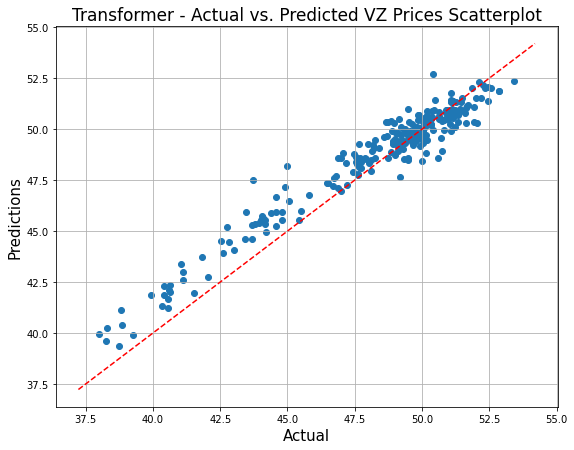

In [ ]:
price_level_evaluation_stats(best_model_test,X_final_train,y_final_train, X_final_test,y_final_test, stock, final_model=True)


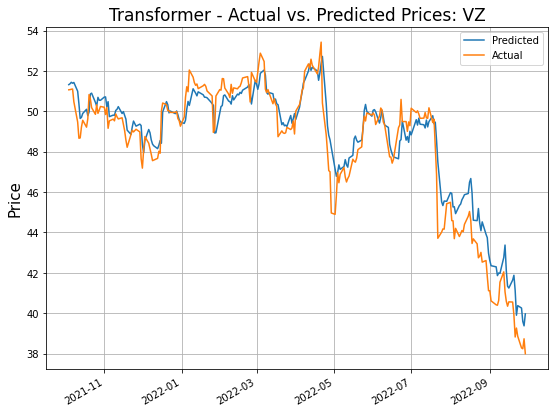

In [40]:
actual_predicted_test_set_chart(best_model_test, X_final_test,y_final_test, model_number)

              precision    recall  f1-score   support

           0       0.59      0.45      0.51       134
           1       0.50      0.64      0.56       115

    accuracy                           0.54       249
   macro avg       0.55      0.55      0.54       249
weighted avg       0.55      0.54      0.53       249

Test Set Accuracy for VZ is 0.5381526104417671






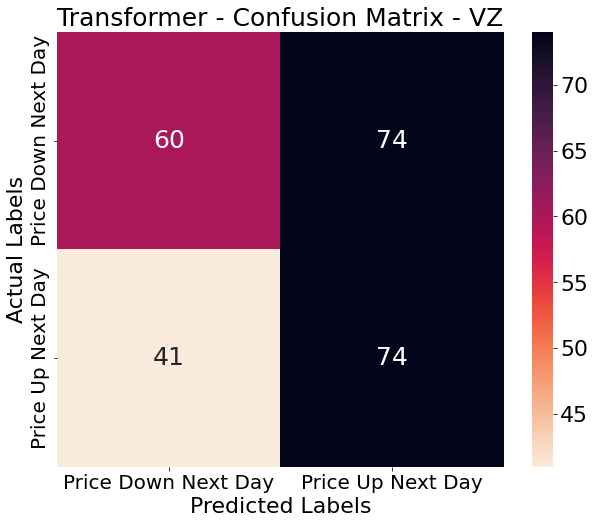

In [ ]:
test_set_classification_report(best_model_test, X_final_test,y_final_test, model_number)

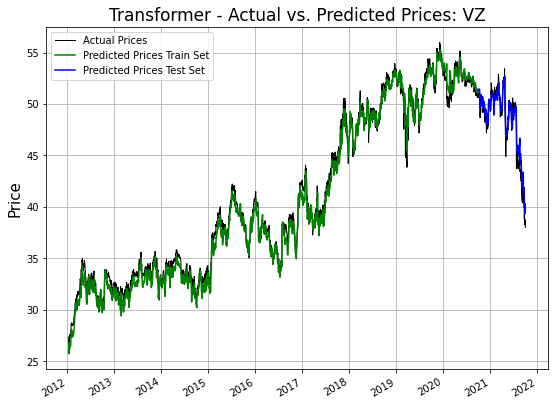

In [ ]:
actual_predicted_train_test_set_chart(best_model_test, X_final_train,y_final_train, X_final_test,y_final_test, model_number)

In [ ]:
#best_model_test.save( '/content/gdrive/My Drive/Colab Notebooks/MSDS_498/saved_models/transformer_model_test_VZ.h5')


In [38]:
best_model_test = tf.keras.models.load_model('/content/gdrive/My Drive/Colab Notebooks/MSDS_498/saved_models/transformer_model_test_VZ.h5',custom_objects={"Time2Vec": Time2Vec })

In [37]:
model_number="VZ"
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


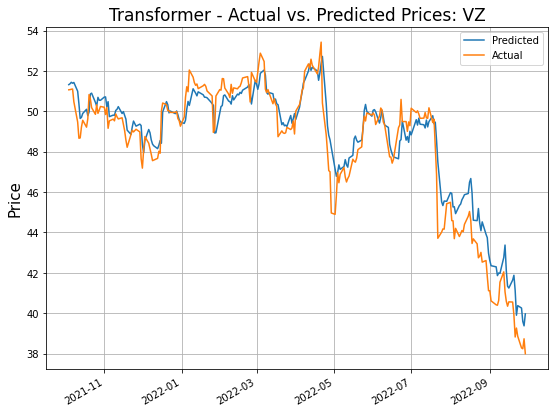

In [39]:
model_number="VZ"
actual_predicted_test_set_chart(best_model_test, X_final_test,y_final_test, model_number)